# Benchmarks analysis

This notebook aims to assess our model's performances on two synthetic benchkmarks of abnormalities:
- deletion benchmark: simple surfaces of various sizes have been randomly deleted
- asymmetry benchmark: equivalent crop but on left hemisphere and then flipped

In [1]:
import os
import sys
import json
import re
import pandas as pd
from tqdm import tqdm
from soma import aims
import random

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)
    
q = os.path.abspath('../../')
if q not in sys.path:
    sys.path.append(q)
    
from vae import *
from preprocess import InpaintDataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import dico_toolbox as dtx
import umap
from scipy.spatial import distance
from scipy.interpolate import interp1d
from scipy.stats import mannwhitneyu, ttest_ind, ks_2samp

from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.svm import LinearSVC

In [2]:
if torch.cuda.is_available():
    device = "cuda:0"

In [3]:
#model_dir = '/volatile/lg261972/inpainting/gridsearch_all/n_100_kl_2_lr_0.0001_bs_8/checkpoint.pt'
model_dir = '/neurospin/dico/lguillon/inpainting/exp_comp/ss_properties/800/checkpoint.pt'
model = VAE((1, 80, 80, 96), 100, depth=3)
model.load_state_dict(torch.load(model_dir))
model = model.to(device)

## Loading of HCP test data

In [4]:
subject_dir = "/neurospin/dico/lguillon/distmap/data/"
data_dir = '/neurospin/dico/data/deep_folding/current/datasets/' \
                        'hcp/crops/1mm/SC/no_mask/'

test_list = pd.read_csv(os.path.join(subject_dir, "test_list.csv"))

filenames = np.load(os.path.join(data_dir, 'Rskeletons', 'sub_id.npy'))
distmaps = np.load(os.path.join(data_dir, 'Rskel_distmaps', "skel_distmap_1mm.npy"),
                   mmap_mode='r')

skeletons = np.load(os.path.join(data_dir, "Rskeletons",
                                "skeletons_1mm.npy"),
                   mmap_mode='r')

foldlabels = np.load(os.path.join(data_dir, 'Rfoldlabels', "foldlabels_1mm.npy"),
                   mmap_mode='r')
    
print(distmaps.shape, filenames.shape)

# Selection of test set only
sorter = np.argsort(filenames)
filenames_idx = sorter[np.searchsorted(filenames, np.array(test_list['subjects']), sorter=sorter)]
filenames = filenames[filenames_idx]
distmaps = distmaps[filenames_idx]
skeletons = skeletons[filenames_idx]
foldlabels = foldlabels[filenames_idx]

print(distmaps.shape)

(1114, 78, 63, 88, 1) (1114,)
(200, 78, 63, 88, 1)


In [5]:
subset = InpaintDataset(foldlabels=foldlabels,
                        skeletons=skeletons,
                        distmaps=distmaps,
                        filenames=filenames,
                        data_transforms=False)
testloader = torch.utils.data.DataLoader(
               subset,
               batch_size=1,
               num_workers=1,
               shuffle=False)

inpaint


In [6]:
dico_set_loaders_hcp = {'hcp': testloader}

root_dir = '/neurospin/dico/lguillon/inpainting/analyses_gridsearch/'

criterion = nn.MSELoss(reduction='sum')
tester_hcp = ModelTester(model=model, dico_set_loaders=dico_set_loaders_hcp,
                     loss_func=criterion, kl_weight=2,
                     n_latent=100, depth=3)

results_hcp = tester_hcp.test()
encoded_hcp = {loader_name:[results_hcp[loader_name][k][1] for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}
losses_hcp = {loader_name:[int(results_hcp[loader_name][k][0].cpu().detach().numpy()) for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}
recon_hcp = {loader_name:[int(results_hcp[loader_name][k][2].cpu().detach().numpy()) for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}
input_hcp = {loader_name:[results_hcp[loader_name][k][3].cpu().detach().numpy() for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}

df_encoded_hcp = pd.DataFrame()
df_encoded_hcp['latent'] = encoded_hcp['hcp'] 
df_encoded_hcp['loss'] = losses_hcp['hcp'] 
df_encoded_hcp['recon'] = recon_hcp['hcp'] 
df_encoded_hcp['input'] = input_hcp['hcp'] 
df_encoded_hcp['Group'] = ['hcp' for k in range(len(filenames))]
df_encoded_hcp['sub'] = list(filenames)

hcp
1183
1756
1727
684
2026
785
920
1674
1007
936
1016
1070
629
871
698
799
678
1783
1125
656
1905
912
826
1339
732
2007
1008
924
992
730
1700
730
1783
1751
550
1559
887
716
1171
930
675
886
895
663
1691
763
936
1796
663
1314
1938
1065
2041
1923
700
752
801
997
1848
1931
1547
1023
788
900
1746
1803
1008
1958
790
1301
1781
831
2215
1903
1919
608
996
1763
770
1744
729
835
626
1612
810
1908
1019
1228
1058
643
1840
568
729
817
866
975
1432
1654
704
1714
1175
949
1837
1249
1862
1535
1794
619
1740
1669
516
1076
971
727
1007
1080
852
864
1203
789
1787
970
523
909
732
889
797
1146
988
501
1676
929
1828
690
1189
2002
1859
907
1074
817
821
638
1073
633
1796
1576
773
1771
908
1760
1670
1823
850
1079
943
684
1711
758
830
721
1373
823
638
626
1847
677
709
1660
663
565
820
1703
566
1028
1927
824
856
1738
606
1108
1470
1948
1045
1044
871
882
663
1754
637
874
944
1149
956
1744
1681
1719
918
1114
657
913


### Loading of deletion benchmark

In [7]:
data_dir = '/neurospin/dico/lguillon/inpainting/benchmark/deletion/'

In [8]:
distmaps_200 = np.load(os.path.join(data_dir, "200", "del_200_distmap.npy"),
                   mmap_mode='r')
skeletons_200 = np.load(os.path.join(data_dir, "200", "del_200_skel.npy"),
                   mmap_mode='r')
foldlabels_200 = np.load(os.path.join(data_dir, "200", "del_200_label.npy"),
                   mmap_mode='r')
filenames_200 = np.load(os.path.join(data_dir, "200", "sub_id_skel.npy"))


subset_200 = InpaintDataset(foldlabels=foldlabels_200,
                        skeletons=skeletons_200,
                        distmaps=distmaps_200,
                        filenames=filenames_200,
                        data_transforms=False)
loader_200 = torch.utils.data.DataLoader(
               subset_200,
               batch_size=1,
               num_workers=1,
               shuffle=False)

distmaps_500 = np.load(os.path.join(data_dir, "500", "del_500_distmap.npy"),
                   mmap_mode='r')
skeletons_500 = np.load(os.path.join(data_dir, "500", "del_500_skel.npy"),
                   mmap_mode='r')
foldlabels_500 = np.load(os.path.join(data_dir, "500", "del_500_label.npy"),
                   mmap_mode='r')
filenames_500 = np.load(os.path.join(data_dir, "500", "sub_id_skel.npy"))


subset_500 = InpaintDataset(foldlabels=foldlabels_500,
                        skeletons=skeletons_500,
                        distmaps=distmaps_500,
                        filenames=filenames_500,
                        data_transforms=False)
loader_500 = torch.utils.data.DataLoader(
               subset_500,
               batch_size=1,
               num_workers=1,
               shuffle=False)

distmaps_700 = np.load(os.path.join(data_dir, "700", "del_700_distmap.npy"),
                   mmap_mode='r')
skeletons_700 = np.load(os.path.join(data_dir, "700", "del_700_skel.npy"),
                   mmap_mode='r')
foldlabels_700 = np.load(os.path.join(data_dir, "700", "del_700_label.npy"),
                   mmap_mode='r')
filenames_700 = np.load(os.path.join(data_dir, "700", "sub_id_skel.npy"))


subset_700 = InpaintDataset(foldlabels=foldlabels_700,
                        skeletons=skeletons_700,
                        distmaps=distmaps_700,
                        filenames=filenames_700,
                        data_transforms=False)
loader_700 = torch.utils.data.DataLoader(
               subset_700,
               batch_size=1,
               num_workers=1,
               shuffle=False)

distmaps_1000 = np.load(os.path.join(data_dir, "1000", "del_1000_distmap.npy"),
                   mmap_mode='r')
skeletons_1000 = np.load(os.path.join(data_dir, "1000", "del_1000_skel.npy"),
                   mmap_mode='r')
foldlabels_1000 = np.load(os.path.join(data_dir, "1000", "del_1000_label.npy"),
                   mmap_mode='r')
filenames_1000 = np.load(os.path.join(data_dir, "1000", "sub_id_skel.npy"))


subset_1000 = InpaintDataset(foldlabels=foldlabels_1000,
                        skeletons=skeletons_1000,
                        distmaps=distmaps_1000,
                        filenames=filenames_1000,
                        data_transforms=False)
loader_1000 = torch.utils.data.DataLoader(
               subset_1000,
               batch_size=1,
               num_workers=1,
               shuffle=False)

inpaint
inpaint
inpaint
inpaint


In [9]:
dico_set_loaders = {'200': loader_200, '500': loader_500, '700': loader_700, '1000': loader_1000}

root_dir = '/neurospin/dico/lguillon/distmap/benchmark/results/'

criterion = nn.MSELoss(reduction='sum')
tester_deletion = ModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=75, depth=3)

results_deletion = tester_deletion.test()
encoded_deletion = {loader_name:[results_deletion[loader_name][k][1] for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
losses_deletion = {loader_name:[int(results_deletion[loader_name][k][0].cpu().detach().numpy()) for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
recon_deletion = {loader_name:[int(results_deletion[loader_name][k][2].cpu().detach().numpy()) for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
input_deletion = {loader_name:[results_deletion[loader_name][k][3].cpu().detach().numpy() for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

200
657
1756
1729
685
2026
786
642
1671
1007
934
608
1070
843
871
809
679
1783
1123
829
1903
1005
834
1339
733
2005
1008
973
960
712
1700
727
1783
1741
551
1558
1029
730
670
936
1103
934
888
671
1691
1795
934
1146
1314
1938
1065
2041
1924
701
1195
929
1848
1547
804
792
898
1747
1803
891
1958
532
1778
834
1903
1919
614
948
1763
772
1744
821
746
939
1400
1350
1905
1019
851
710
643
1842
1090
1396
739
567
530
1655
1025
618
717
916
1838
513
1863
1535
618
968
1741
1669
924
969
727
635
1076
852
865
1203
1059
1787
1453
1309
910
731
892
1384
1143
780
1526
1676
1828
692
887
2002
907
868
817
1087
1073
709
1796
1578
819
766
830
1628
1670
1823
850
1079
900
1109
1711
763
831
937
1372
807
1075
540
1660
666
563
824
1703
562
1028
1931
1818
858
1736
1108
563
506
598
877
1754
1102
871
773
1742
1677
1718
917
843
657
918
500
659
684
928
1020
1078
845
839
1125
830
1002
1341
714
1170
1106
934
1077
1065
1146
1315
721
997
1301
834
728
825
939
792
1396
571
977
1439
1654
1713
1250
1794
968
1669
1613
1008
864
130

AttributeError: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/casa/home/.local/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/casa/home/.local/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/casa/home/.local/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/neurospin/dico/lguillon/2022_lguillon_foldInpainting/preprocess.py", line 149, in __getitem__
    skeleton, target = b(skeleton)
  File "/casa/home/.local/lib/python3.6/site-packages/torchvision/transforms/transforms.py", line 61, in __call__
    img = t(img)
  File "/neurospin/dico/lguillon/2022_lguillon_foldInpainting/preprocess.py", line 269, in __call__
    self.foldlabel[self.foldlabel==self.fold] = 9999
AttributeError: 'randomSuppression' object has no attribute 'fold'


1108


In [152]:
df_encoded_deletion = pd.DataFrame()
df_encoded_deletion['latent'] = encoded_deletion['200'] +encoded_deletion['500']+ encoded_deletion['700'] +encoded_deletion['1000']  
df_encoded_deletion['loss'] = losses_deletion['200'] + losses_deletion['500'] + losses_deletion['700'] + losses_deletion['1000'] 
df_encoded_deletion['recon'] = recon_deletion['200'] + recon_deletion['500'] +recon_deletion['700'] + recon_deletion['1000']  
df_encoded_deletion['input'] = input_deletion['200'] + input_deletion['500'] + input_deletion['700'] + input_deletion['1000']
df_encoded_deletion['sub'] = list(filenames_200) + list(filenames_500) + list(filenames_700) + list(filenames_1000)
df_encoded_deletion['group'] = ['200' for k in range(len(list(filenames_200)))] + ['500' for k in range(len(list(filenames_500)))] + ['700' for k in range(len(list(filenames_700)))] + ['1000' for k in range(len(list(filenames_1000)))]

In [153]:
deletion_200 = pd.DataFrame()
deletion_200['latent'] = encoded_deletion['200']
deletion_200['loss'] = losses_deletion['200']  
deletion_200['recon'] = recon_deletion['200']   
deletion_200['input'] = input_deletion['200'] 
deletion_200['sub'] = list(filenames_200) 

In [154]:
deletion_500 = pd.DataFrame()
deletion_500['latent'] = encoded_deletion['500']  
deletion_500['loss'] = losses_deletion['500'] 
deletion_500['recon'] = recon_deletion['500']  
deletion_500['input'] = input_deletion['500']
deletion_500['sub'] = list(filenames_500)

deletion_700 = pd.DataFrame()
deletion_700['latent'] = encoded_deletion['700']  
deletion_700['loss'] = losses_deletion['700'] 
deletion_700['recon'] = recon_deletion['700']  
deletion_700['input'] = input_deletion['700']
deletion_700['sub'] = list(filenames_700)

deletion_1000 = pd.DataFrame()
deletion_1000['latent'] = encoded_deletion['1000']  
deletion_1000['loss'] = losses_deletion['1000'] 
deletion_1000['recon'] = recon_deletion['1000']  
deletion_1000['input'] = input_deletion['1000']
deletion_1000['sub'] = list(filenames_1000)

In [155]:
df_200_500 = pd.merge(deletion_200, deletion_500, how='inner', on='sub')
df_700_1000 = pd.merge(deletion_700, deletion_1000, how='inner', on='sub')
deletion_all = pd.merge(df_200_500, df_700_1000, how='inner', on='sub')

In [156]:
len(deletion_all)

10

### Benchmark 200

In [157]:
list_encoded_200 = random.sample(list(deletion_200['sub']), 100)
df_encoded_200_X = deletion_200[deletion_200['sub'].astype(int).isin(list_encoded_200)]

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_200_X['sub'].astype(int))))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

In [158]:
random_ctrl = random.sample(list(df_encoded_hcp['sub'][:200]), 100)

In [159]:
random_deletion = list(set(list(deletion_200['sub'].astype(int))) - set(random_ctrl))

In [160]:
df_encoded_200_X = deletion_200[deletion_200['sub'].astype(int).isin(random_deletion)]
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(random_ctrl)]

In [161]:
X_200 = np.array(list(df_encoded_200_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X['latent']))
X_all = np.array(list(df_encoded_hcp_X['latent']) + list(df_encoded_200_X['latent']))

from sklearn.manifold import TSNE
# X_embedded_200 = TSNE(n_components=2).fit_transform(X_all)
labels_200 = np.array(list(df_encoded_hcp_X['Group']) + ['200' for k in range(len(df_encoded_200_X))])

In [162]:
reducer = umap.UMAP()
embedding_200 = reducer.fit_transform(X_all)

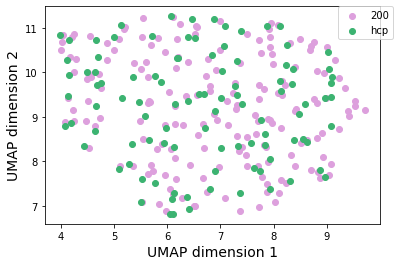

In [163]:
arr = embedding_200
color_dict = {'hcp':'mediumseagreen', '200': 'plum'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_200):
    ix = np.where(labels_200 == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

### Benchmark 500

In [164]:
df_encoded_500_X = deletion_500

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(deletion_500['sub'].astype(int))))
random_ctrl = random.sample(list_ctrl, 100)
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(random_ctrl)]

In [165]:
X_500 = np.array(list(df_encoded_500_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X['latent']))
X_all = np.array(list(df_encoded_hcp_X['latent']) + list(df_encoded_500_X['latent']))

#X_embedded_500 = TSNE(n_components=2).fit_transform(X_all)
labels_500 = np.array(list(df_encoded_hcp_X['Group']) + ['500' for k in range(len(df_encoded_500_X))])
reducer = umap.UMAP()
embedding_500 = reducer.fit_transform(X_all)

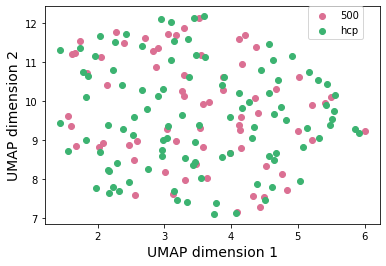

In [166]:
arr = embedding_500
color_dict = {'hcp':'mediumseagreen', '500': 'palevioletred'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_500):
    ix = np.where(labels_500 == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(0.95,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

### Benchmark 700

In [25]:
list_encoded_700 = random.sample(list(deletion_700['sub']), 100)
df_encoded_700_X = deletion_700[deletion_700['sub'].astype(int).isin(list_encoded_700)]

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_700_X['sub'].astype(int))))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

In [167]:
X_700 = np.array(list(df_encoded_700_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X['latent']))
X_all = np.array(list(df_encoded_hcp_X['latent']) + list(df_encoded_700_X['latent']))

#X_embedded_700 = TSNE(n_components=2).fit_transform(X_all)
labels_700 = np.array(list(df_encoded_hcp_X['Group']) + ['700' for k in range(len(df_encoded_700_X))])
reducer = umap.UMAP()
embedding_700 = reducer.fit_transform(X_all)

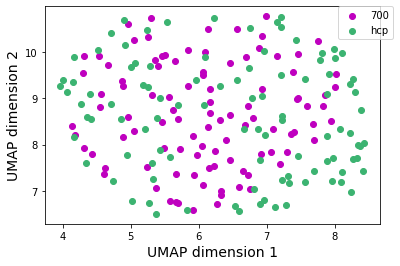

In [168]:
arr = embedding_700
color_dict = {'hcp':'mediumseagreen', '700': 'm'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_700):
    ix = np.where(labels_700 == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

### Benchmark 1000

In [169]:
list_encoded_1000 = random.sample(list(deletion_1000['sub']), 100)
df_encoded_1000_X = deletion_1000[deletion_1000['sub'].astype(int).isin(list_encoded_1000)]

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_1000_X['sub'].astype(int))))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

In [170]:
X_1000 = np.array(list(df_encoded_1000_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X['latent']))
X_all = np.array(list(df_encoded_hcp_X['latent']) + list(df_encoded_1000_X['latent']))

#X_embedded_1000 = TSNE(n_components=2, perplexity=15).fit_transform(X_all)
labels_1000 = np.array(list(df_encoded_hcp_X['Group']) + ['1000' for k in range(len(df_encoded_1000_X))])
reducer = umap.UMAP()
embedding_1000 = reducer.fit_transform(X_all)

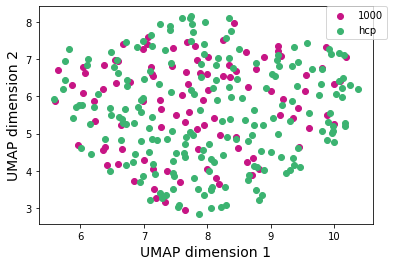

In [171]:
arr = embedding_1000
color_dict = {'hcp':'mediumseagreen', '1000': 'mediumvioletred'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_1000):
    ix = np.where(labels_1000 == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

### ALL

In [172]:
X = np.array(list(df_encoded_hcp['latent']) +
             list(deletion_200['latent']) +
             list(deletion_500['latent']) +
             list(deletion_700['latent']) +
             list(deletion_1000['latent']))
labels = np.array(list(df_encoded_hcp['Group']) + 
                  ['200' for k in range(len(deletion_200))] +
                  ['500' for k in range(len(deletion_500))] +
                  ['700' for k in range(len(deletion_700))] +
                  ['1000' for k in range(len(deletion_1000))])
reducer = umap.UMAP()
embedding_all = reducer.fit_transform(X)

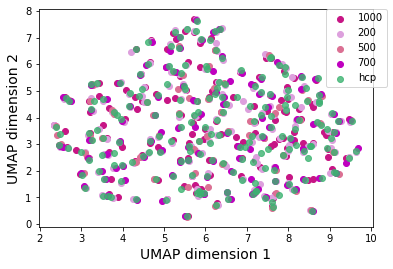

In [173]:
arr = embedding_all
color_dict = {'hcp':'mediumseagreen', '200': 'plum', '500': 'palevioletred', '700': 'm', '1000': 'mediumvioletred'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels):
    ix = np.where(labels == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    if g=='hcp':
        ax.scatter(x, y, c = color_dict[g], label = g_lab, alpha=0.8)
    else:
        ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

In [36]:
embedding = np.array(list(embedding_all[:200]) + list(embedding_all[-151:]))

fp_list = {'oc':[], 'lof':[], 'if':[]}
tp_list = {'oc':[], 'lof':[], 'if':[]}
undetected_sub_oc = []
undetected_sub_if = []
fp_random = {}
tp_random = {}

for k in np.arange(0.05, 1, 0.01):
    tp_random[k] = []
    fp_random[k] = []
    clf = OneClassSVM(nu=k).fit(embedding)
    pred_ctrl = clf.predict(embedding)[:200]
    pred_1000 = clf.predict(embedding)[200:]
    fp_list['oc'].append(len(pred_ctrl[pred_ctrl==-1])/200)
    tp_list['oc'].append(len(pred_1000[pred_1000==-1])/151)
    undetected_sub_oc.append(np.where(pred_1000[pred_1000==1]))
    nb_outliers = len(clf.predict(embedding)[clf.predict(embedding)==-1])
    for i in range(1000):
        rand_outliers = np.array(random.sample(range(351), 151))
        tp_random[k].append(len(rand_outliers[rand_outliers>=200])/151)
        fp_random[k].append(len(rand_outliers[rand_outliers<200])/200)

    
    clf = IsolationForest(random_state=10, contamination=k).fit(embedding)
    pred_ctrl = clf.predict(embedding)[:200]
    pred_1000 = clf.predict(embedding)[200:]
    fp_list['if'].append(len(pred_ctrl[pred_ctrl==-1])/200)
    tp_list['if'].append(len(pred_1000[pred_1000==-1])/151)
    undetected_sub_if.append(np.where(pred_1000[pred_1000==1]))

In [37]:
mean_random_fp = [np.mean(fp_random[k]) for k in fp_random.keys()]
mean_random_tp = [np.mean(tp_random[k]) for k in tp_random.keys()]

quantile_5_random_fp = [np.quantile(fp_random[k], 0.05) for k in fp_random.keys()]
quantile_5_random_tp = [np.quantile(tp_random[k], 0.05) for k in tp_random.keys()]

quantile_95_random_fp = [np.quantile(fp_random[k], 0.95) for k in fp_random.keys()]
quantile_95_random_tp = [np.quantile(tp_random[k], 0.95) for k in tp_random.keys()]

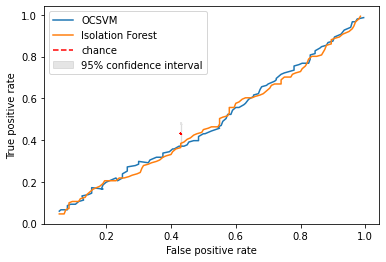

In [38]:
plt.subplot()
plt.plot(fp_list['oc'], tp_list['oc'], label='OCSVM')
plt.plot(fp_list['if'], tp_list['if'], label='Isolation Forest')

plt.plot(mean_random_fp, mean_random_tp, linestyle='--', label='chance', c='r')
#plt.plot(quantile_5_random_fp, quantile_5_random_tp, label='5th quantile')
#plt.plot(quantile_95_random_fp, quantile_95_random_tp, label='95th percentile')

plt.fill_between(mean_random_fp, quantile_5_random_tp, quantile_95_random_tp, color='grey', alpha=.2,
            label=f"95% confidence interval")


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.show()

## Trajectories

In [39]:
df_200_500 = pd.merge(deletion_200, deletion_500, how='inner', on='sub', suffixes=('_200', '_500'))
df_700_1000 = pd.merge(deletion_700, deletion_1000, how='inner', on='sub', suffixes=('_700', '_1000'))
deletion_all = pd.merge(df_200_500, df_700_1000, how='inner', on='sub')

In [80]:
deletion_all.head()

,latent_200,loss_200,recon_200,input_200,sub,latent_500,loss_500,recon_500,input_500,latent_700,loss_700,recon_700,input_700,latent_1000,loss_1000,recon_1000,input_1000
0,"[-0.38987058, 1.814859, 0.6110011, 0.21380988,...",1881,1613,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,628248,"[-0.044629645, 1.3369011, -0.4782747, 0.305772...",2021,1752,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,"[-0.6086889, -0.060489498, -0.0039648614, 0.52...",2489,2224,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,"[-0.7531484, 0.8431534, 0.933035, -1.0674897, ...",2465,2194,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....
1,"[-1.3145444, 0.2910724, 0.3596519, 1.2406789, ...",1828,1550,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,878877,"[-2.3361673, 0.6332646, -0.8050137, 1.9601942,...",1803,1512,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,"[-1.5976859, 0.5088612, 0.62651557, -0.4510358...",2268,2002,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,"[-1.5822557, 0.86050135, -0.121944055, -0.3983...",2519,2258,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....
2,"[-0.7689903, -1.6160225, 0.5808759, -0.2395777...",2890,2598,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,329440,"[-0.373356, -2.3229465, -0.10135569, 1.2018762...",3029,2739,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,"[-0.67647934, -0.9276844, 0.60801345, -0.90769...",3094,2797,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,"[0.20771417, -0.4633176, 1.1051017, -0.5104590...",3675,3410,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....
3,"[1.062052, -0.4035468, -0.040406413, -1.608239...",1920,1656,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,453441,"[0.81158435, 0.1530474, -0.8546037, 0.19122915...",2092,1826,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,"[0.40803728, -1.013699, -0.42519957, -1.639501...",2440,2194,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,"[0.6916935, 0.06509067, 0.69490206, -1.391059,...",2632,2368,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....
4,"[0.6155589, -1.6795915, 0.39211455, -0.9378491...",1753,1484,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,131722,"[-0.23466806, -1.0603116, -0.34790367, -0.6298...",1872,1596,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,"[-0.84548813, -0.97294533, 0.046896454, -1.632...",2592,2333,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,"[0.6891677, -1.8516729, 0.6179161, -1.1969818,...",2491,2206,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....


In [40]:
list_encoded_all = list(deletion_all['sub'])
df_encoded_all_X = deletion_all

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_all_X['sub'].astype(int))))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

In [41]:
X_del_all = np.array(list(df_encoded_all_X['latent_200']) + list(df_encoded_all_X['latent_500']) + list(df_encoded_all_X['latent_700']) + list(df_encoded_all_X['latent_1000']))
X_hcp = np.array(list(df_encoded_hcp_X['latent']))
X_all = np.array(list(df_encoded_hcp_X['latent']) + list(df_encoded_all_X['latent_200']) + list(df_encoded_all_X['latent_500']) + list(df_encoded_all_X['latent_700']) + list(df_encoded_all_X['latent_1000']))

labels_all =np.array(list(df_encoded_hcp_X['Group']) + ['200' for k in range(10)] + ['500' for k in range(10)] + ['700' for k in range(10)] + ['1000' for k in range(10)])
reducer = umap.UMAP()
embedding_all = reducer.fit_transform(X_all)

In [42]:
X_all = np.array(list(df_encoded_hcp_X['latent']) + [df_encoded_all_X[k][0] for k in ['latent_200', 'latent_500', 'latent_700', 'latent_1000']] +
                                                    [df_encoded_all_X[k][1] for k in ['latent_200', 'latent_500', 'latent_700', 'latent_1000']] +
                                                    [df_encoded_all_X[k][2] for k in ['latent_200', 'latent_500', 'latent_700', 'latent_1000']] +
                                                    [df_encoded_all_X[k][3] for k in ['latent_200', 'latent_500', 'latent_700', 'latent_1000']] +
                                                    [df_encoded_all_X[k][4] for k in ['latent_200', 'latent_500', 'latent_700', 'latent_1000']] +
                                                    [df_encoded_all_X[k][5] for k in ['latent_200', 'latent_500', 'latent_700', 'latent_1000']] +
                                                    [df_encoded_all_X[k][6] for k in ['latent_200', 'latent_500', 'latent_700', 'latent_1000']] +
                                                    [df_encoded_all_X[k][7] for k in ['latent_200', 'latent_500', 'latent_700', 'latent_1000']] +
                                                    [df_encoded_all_X[k][8] for k in ['latent_200', 'latent_500', 'latent_700', 'latent_1000']] +
                                                    [df_encoded_all_X[k][9] for k in ['latent_200', 'latent_500', 'latent_700', 'latent_1000']] )

labels_all = np.array(list(df_encoded_hcp_X['Group']) + ['200' for k in range(10)] + ['500' for k in range(10)] + ['700' for k in range(10)] + ['1000' for k in range(10)])
reducer = umap.UMAP()
# embedding_all = reducer.fit_transform(X_all)
embedding_all = reducer.fit_transform(np.array(list(df_encoded_hcp_X['latent'])))

In [43]:
embedding_del = reducer.transform(X_del_all)

['1000' '200' '500' '700' 'hcp']


IndexError: index 230 is out of bounds for axis 0 with size 200

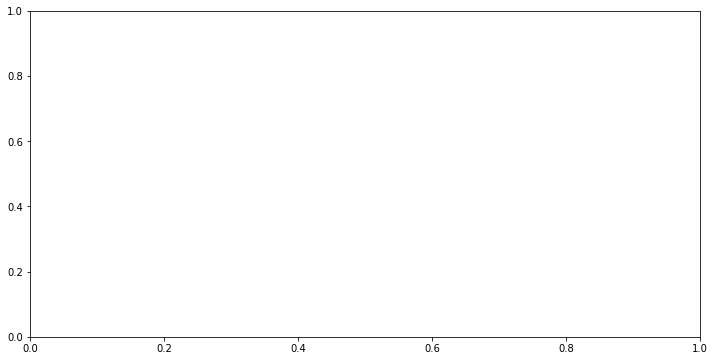

In [44]:
arr = embedding_all
color_dict = {'hcp':'mediumseagreen', 'sub1': 'blue', 'sub2': 'red', 'sub3':'orange', 'sub4': 'magenta',
             'sub5': 'lightblue', 'sub6': 'yellow', 'sub7':'plum', 'sub8': 'lightseagreen','sub9':'forestgreen'}
marker_dict = {'hcp': 'o', '200': 'x', '500': 'v', '700': '^', '1000': 'D'}

fig = plt.figure(figsize=(12,6))
ax = fig.subplots()

print( np.unique(labels_all))
for g in np.unique(labels_all):
    ix = np.where(labels_all == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    if g=='hcp':
        ax.scatter(x, y, color='mediumseagreen', label = g_lab, marker=marker_dict[g])
    else:
        for i in ix:
            print(i)
            if 190 in i:
                print(g)
                ax.scatter(x, y, c=color_dict['sub1'], label = g_lab, marker=marker_dict[g])
            elif 191 in i:
                ax.scatter(x, y, c=color_dict['sub2'], label = g_lab, marker=marker_dict[g])
            elif 192 in i:
                ax.scatter(x, y, c=color_dict['sub3'], label = g_lab, marker=marker_dict[g])
            elif 193 in i:
                ax.scatter(x, y, c=color_dict['sub4'], label = g_lab, marker=marker_dict[g])
    
#plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

['1000' '200' '500' '700' 'hcp']


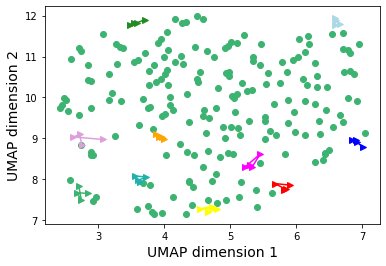

In [189]:
arr = embedding_all
color_dict = {'hcp':'mediumseagreen', 'sub1': 'blue', 'sub2': 'red', 'sub3':'orange', 'sub4': 'magenta',
             'sub5': 'lightblue', 'sub6': 'yellow', 'sub7':'plum', 'sub8': 'lightseagreen','sub9':'forestgreen'}
marker_dict = {'hcp': 'o', '200': 'x', '500': 'v', '700': '^', '1000': 'D'}

fig = plt.figure()
ax = fig.subplots()

print( np.unique(labels_all))
for g in np.unique(labels_all):
    ix = np.where(labels_all == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    if g=='hcp':
        ax.scatter(x, y, color='mediumseagreen', label = g_lab, marker=marker_dict[g])
for idx, k in enumerate(range(190, 227, 4)):
    ax.plot([embedding_all[k:k+4][i][0] for i in range(4)], 
            [embedding_all[k:k+4][i][1] for i in range(4)], '->',c=list(color_dict.values())[idx])

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

In [45]:
embedding_del.shape

(40, 2)

['1000' '200' '500' '700' 'hcp']


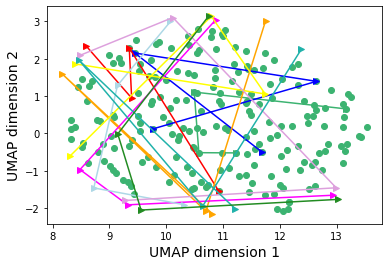

In [47]:
arr = np.array(list(embedding_all) + list(embedding_del))
color_dict = {'hcp':'mediumseagreen', 'sub1': 'blue', 'sub2': 'red', 'sub3':'orange', 'sub4': 'magenta',
             'sub5': 'lightblue', 'sub6': 'yellow', 'sub7':'plum', 'sub8': 'lightseagreen','sub9':'forestgreen'}
marker_dict = {'hcp': 'o', '200': 'x', '500': 'v', '700': '^', '1000': 'D'}

fig = plt.figure()
ax = fig.subplots()

print( np.unique(labels_all))
for g in np.unique(labels_all):
    ix = np.where(labels_all == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    if g=='hcp':
        ax.scatter(x, y, color='mediumseagreen', label = g_lab, marker=marker_dict[g])
for idx, k in enumerate(range(190, 227, 4)):
    ax.plot([arr[k:k+4][i][0] for i in range(4)], 
            [arr[k:k+4][i][1] for i in range(4)], '->',c=list(color_dict.values())[idx])

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

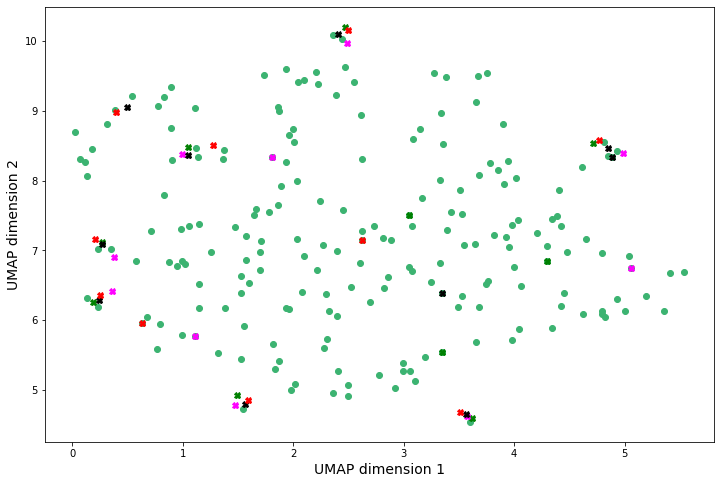

In [48]:
reducer = umap.UMAP()
embedding_all = reducer.fit_transform(X_all)

arr = embedding_all
color_dict = {'hcp':'mediumseagreen', 'sub1': 'blue', 'sub2': 'red', 'sub3':'orange', 'sub4': 'magenta',
             'sub5': 'lightblue', 'sub6': 'yellow', 'sub7':'plum', 'sub8': 'lightseagreen','sub9':'black'}
marker_dict = {'hcp': 'o', '200': 'x', '500': 'v', '700': '^', '1000': 'D'}

fig = plt.figure(figsize=(12,8))
ax = fig.subplots()

for g in np.unique(labels_all):
    ix = np.where(labels_all == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    if g=='hcp':
        ax.scatter(x, y, color='mediumseagreen', label = g_lab, marker=marker_dict[g])
# for idx, k in enumerate(range(190, 227, 4)):
#     ax.plot([embedding_all[k:k+4][i][0] for i in range(0, 4, 1)], 
#             [embedding_all[k:k+4][i][1] for i in range(0, 4, 1)], '-->', c='magenta')
for idx, k in enumerate(range(190, 227, 4)):
    ax.plot([embedding_all[k:k+4][0][0]], 
            [embedding_all[k:k+4][0][1]], 'X', c='green')
for idx, k in enumerate(range(190, 227, 4)):
    ax.plot([embedding_all[k:k+4][1][0]], 
            [embedding_all[k:k+4][1][1]], 'X', c='magenta')
for idx, k in enumerate(range(190, 227, 4)):
    ax.plot([embedding_all[k:k+4][2][0]], 
            [embedding_all[k:k+4][2][1]], 'X', c='black')
for idx, k in enumerate(range(190, 227, 4)):
    ax.plot([embedding_all[k:k+4][3][0]], 
            [embedding_all[k:k+4][3][1]], 'X', c='red')

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

### Trajectory 200-1000

In [298]:
df_200_1000

,latent_200,loss_200,recon_200,input_200,sub,latent_1000,loss_1000,recon_1000,input_1000
0,"[-0.2905898, -0.013959071, -0.8990595, 0.04761...",2321,2031,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,887373,"[1.0376589, 0.97603214, 0.71130496, -0.8217206...",2767,2497,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....
1,"[0.96034926, -0.5365658, -3.028193, 1.6349615,...",1759,1475,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,463040,"[1.1364107, -0.6994087, -1.4922446, -0.2872049...",2437,2167,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....
2,"[0.9319158, -2.320161, 1.2870122, -1.3713944, ...",1733,1460,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,137431,"[-0.37107432, -2.0106165, 1.193153, -1.9291915...",3420,3174,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....
3,"[0.70671856, -1.6163287, 1.6162556, 0.36796257...",1904,1622,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,203721,"[0.88102406, -1.7977341, 1.1382779, 0.02665004...",2531,2265,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....
4,"[-0.6444578, 0.67964387, -0.4960109, 1.9705592...",2447,2170,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,802844,"[-0.9305126, -0.3653895, -1.2055594, 0.69715, ...",2950,2689,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....
5,"[0.31185654, -0.36341026, 0.6696028, 0.3263350...",2016,1735,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,190031,"[-0.19770782, -0.75873595, 0.8541647, -0.86429...",2663,2402,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....
6,"[0.47201747, 1.7895805, -2.046327, -1.2068485,...",2008,1736,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,186040,"[0.0041039027, 0.22494437, 0.17868397, -1.6989...",2839,2569,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....
7,"[0.74711174, 0.61888677, 0.64987326, 0.8616992...",2222,1941,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,210112,"[-0.47188058, -0.25031614, 0.7847943, 0.390837...",2760,2506,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....
8,"[-0.38987058, 1.814859, 0.6110011, 0.21380988,...",1881,1613,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,628248,"[-0.7531484, 0.8431534, 0.933035, -1.0674897, ...",2465,2194,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....
9,"[2.6438036, -0.7606913, -2.1411216, 0.27718657...",1816,1550,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,601127,"[2.3098326, -0.9731301, -0.49097463, -1.728106...",2682,2422,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....


In [49]:
df_200_1000 = pd.merge(deletion_200, deletion_1000, how='inner', on='sub', suffixes=('_200', '_1000'))

list_encoded_all = list(df_200_1000['sub'])[:200]
df_200_1000_X = df_200_1000

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_200_1000_X['sub'][:20].astype(int))))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

X_all = np.array(list(df_encoded_hcp_X['latent']) + [df_200_1000[k][0] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][1] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][2] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][3] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][4] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][5] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][6] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][7] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][8] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][9] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][10] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][11] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][12] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][13] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][14] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][15] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][16] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][17] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][18] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][19] for k in ['latent_200', 'latent_1000']] )

labels_all = np.array(list(df_encoded_hcp_X['Group']) + ['200' for k in range(20)] + ['1000' for k in range(20)])
reducer = umap.UMAP()
embedding_all = reducer.fit_transform(X_all)

In [50]:
len(list(df_encoded_hcp_X['Group']))

200

In [51]:
embedding_all.shape

(240, 2)

['1000' '200' 'hcp']


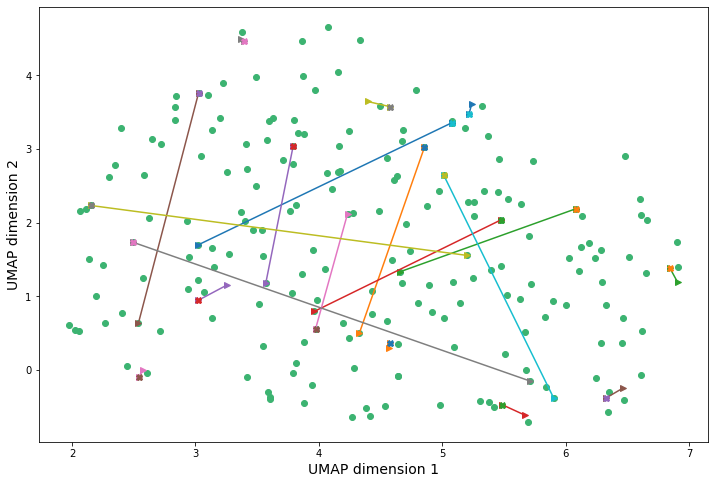

In [52]:
arr = embedding_all
color_dict = {'hcp':'mediumseagreen', 'sub1': 'blue', 'sub2': 'red', 'sub3':'orange', 'sub4': 'magenta',
             'sub5': 'lightblue', 'sub6': 'yellow', 'sub7':'plum', 'sub8': 'lightseagreen','sub9':'forestgreen'}
marker_dict = {'hcp': 'o', '200': 'x', '500': 'v', '700': '^', '1000': 'D'}

fig = plt.figure(figsize=(12,8))
ax = fig.subplots()

print( np.unique(labels_all))
for g in np.unique(labels_all):
    ix = np.where(labels_all == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    if g=='hcp':
        ax.scatter(x, y, color='mediumseagreen', label = g_lab, marker=marker_dict[g])
for idx, k in enumerate(range(180, 217, 2)):
    ax.plot([embedding_all[k:k+2][i][0] for i in range(2)], 
            [embedding_all[k:k+2][i][1] for i in range(2)], '->')
for idx, k in enumerate(range(180, 217, 2)):
    ax.plot([embedding_all[k:k+2][0][0]], 
            [embedding_all[k:k+2][0][1]], 'X')

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

### Quantification

#### SS_size = 200

In [174]:
X_200 = np.array(list(df_encoded_200_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X['latent']))

X = np.array(list(df_encoded_hcp_X['latent']) + list(df_encoded_200_X['latent']))
label = np.array(['hcp' for k in range(len(X_hcp))] + ['200' for k in range(len(X_200))])

X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.4, stratify=label, random_state=42)

/casa/home/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


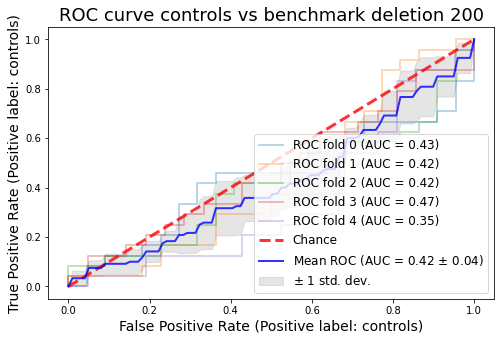

In [175]:
cv = StratifiedKFold(n_splits=5)
gb = LogisticRegression(random_state=0)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(8, 5))
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    gb.fit(X_train[train], y_train[train])
    viz = metrics.plot_roc_curve(gb, X_train[test], y_train[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large')
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark deletion 200', fontsize=18)
plt.show()

In [61]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
cv_outer = StratifiedKFold(n_splits=5)

outer_results = list()
for train_ix, test_ix in cv_outer.split(X, label):
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = label[train_ix], label[test_ix]
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    model = LinearSVC(random_state=1, loss='squared_hinge', max_iter=10000)
    space = dict()
    space['penalty'] = ['l2']
    space['C'] = [0.7, 1, 1.2]
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

>acc=0.625, est=0.518, cfg={'C': 1, 'penalty': 'l2'}
>acc=0.554, est=0.501, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.446, est=0.500, cfg={'C': 1.2, 'penalty': 'l2'}
>acc=0.500, est=0.486, cfg={'C': 1.2, 'penalty': 'l2'}
>acc=0.500, est=0.500, cfg={'C': 1.2, 'penalty': 'l2'}
Accuracy: 0.525 (0.060)


>acc=0.625, est=0.518, cfg={'C': 1, 'penalty': 'l2'}
>acc=0.554, est=0.501, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.446, est=0.500, cfg={'C': 1.2, 'penalty': 'l2'}
>acc=0.500, est=0.486, cfg={'C': 1.2, 'penalty': 'l2'}
>acc=0.500, est=0.500, cfg={'C': 1.2, 'penalty': 'l2'}


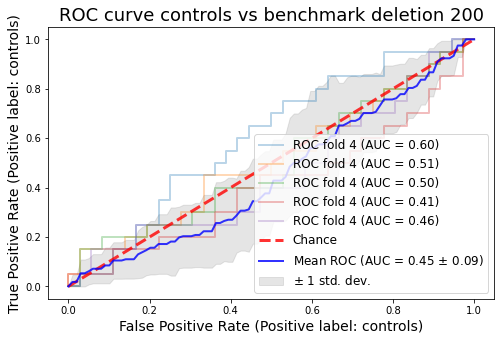

Accuracy: 0.525 (0.060)


In [62]:
fig, ax = plt.subplots(figsize=(8, 5))

cv_outer = StratifiedKFold(n_splits=5)

outer_results = list()
for train_ix, test_ix in cv_outer.split(X, label):
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = label[train_ix], label[test_ix]
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    model = LinearSVC(random_state=1, loss='squared_hinge', max_iter=10000)
    space = dict()
    space['penalty'] = ['l2']
    space['C'] = [0.7, 1, 1.2]
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        
    viz = metrics.plot_roc_curve(best_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large')
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark deletion 200', fontsize=18)
plt.show()
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

#### SS_size = 500

In [176]:
df_encoded_500_X = deletion_500

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(deletion_500['sub'].astype(int))))
random_ctrl = random.sample(list_ctrl, 100)
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(random_ctrl)]

X_500 = np.array(list(df_encoded_500_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X['latent']))
X = np.array(list(df_encoded_hcp_X['latent']) + list(df_encoded_500_X['latent']))

#X_embedded_500 = TSNE(n_components=2).fit_transform(X_all)
label = np.array(list(df_encoded_hcp_X['Group']) + ['500' for k in range(len(df_encoded_500_X))])

X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.4, stratify=label, random_state=42)

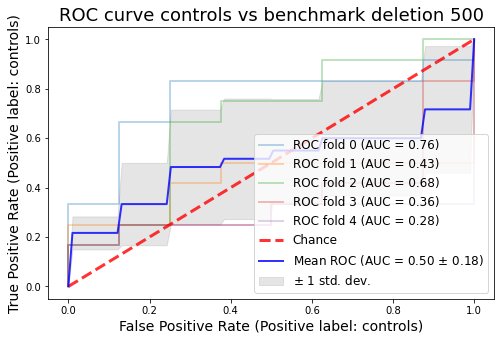

In [177]:
cv = StratifiedKFold(n_splits=5)
gb = LogisticRegression(random_state=12)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(8, 5))
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    gb.fit(X_train[train], y_train[train])
    viz = metrics.plot_roc_curve(gb, X_train[test], y_train[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large')
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark deletion 500', fontsize=18)
plt.show()

In [497]:
cv_outer = StratifiedKFold(n_splits=5)

outer_results = list()
for train_ix, test_ix in cv_outer.split(X, label):
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = label[train_ix], label[test_ix]
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    model = LinearSVC(random_state=1, loss='squared_hinge', max_iter=10000)
    space = dict()
    space['penalty'] = ['l2']
    space['C'] = [0.7, 1, 1.2]
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

>acc=0.794, est=0.619, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.647, est=0.582, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.529, est=0.582, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.576, est=0.630, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.606, est=0.659, cfg={'C': 1, 'penalty': 'l2'}
Accuracy: 0.630 (0.090)


>acc=0.794, est=0.619, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.647, est=0.582, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.529, est=0.582, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.576, est=0.630, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.606, est=0.659, cfg={'C': 1, 'penalty': 'l2'}


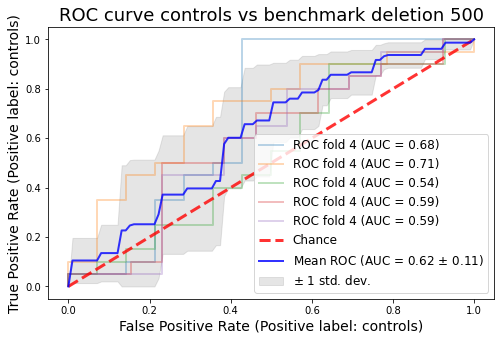

Accuracy: 0.630 (0.090)


In [498]:
fig, ax = plt.subplots(figsize=(8, 5))

cv_outer = StratifiedKFold(n_splits=5)

outer_results = list()
for train_ix, test_ix in cv_outer.split(X, label):
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = label[train_ix], label[test_ix]
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    model = LinearSVC(random_state=1, loss='squared_hinge', max_iter=10000)
    space = dict()
    space['penalty'] = ['l2']
    space['C'] = [0.7, 1, 1.2]
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        
    viz = metrics.plot_roc_curve(best_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large')
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark deletion 500', fontsize=18)
plt.show()
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

#### SS_size = 700

In [178]:
list_encoded_700 = random.sample(list(deletion_700['sub']), 100)
df_encoded_700_X = deletion_700[deletion_700['sub'].astype(int).isin(list_encoded_700)]

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_700_X['sub'].astype(int))))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

X_700 = np.array(list(df_encoded_700_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X['latent']))
X = np.array(list(df_encoded_hcp_X['latent']) + list(df_encoded_700_X['latent']))

#X_embedded_700 = TSNE(n_components=2).fit_transform(X_all)
label = np.array(list(df_encoded_hcp_X['Group']) + ['700' for k in range(len(df_encoded_700_X))])

X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.4, stratify=label, random_state=42)

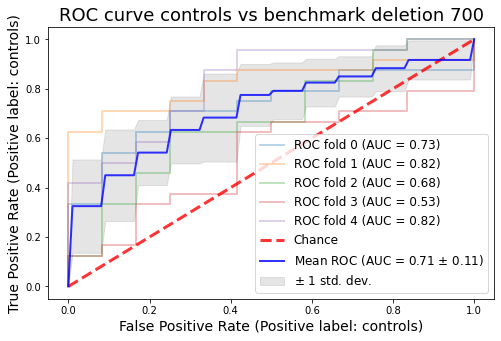

In [179]:
cv = StratifiedKFold(n_splits=5)
gb = LogisticRegression()

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(8, 5))
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    gb.fit(X_train[train], y_train[train])
    viz = metrics.plot_roc_curve(gb, X_train[test], y_train[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large')
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark deletion 700', fontsize=18)
plt.show()

>acc=0.650, est=0.604, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.650, est=0.671, cfg={'C': 1.2, 'penalty': 'l2'}
>acc=0.717, est=0.613, cfg={'C': 1, 'penalty': 'l2'}
>acc=0.717, est=0.621, cfg={'C': 1, 'penalty': 'l2'}
>acc=0.617, est=0.629, cfg={'C': 1, 'penalty': 'l2'}


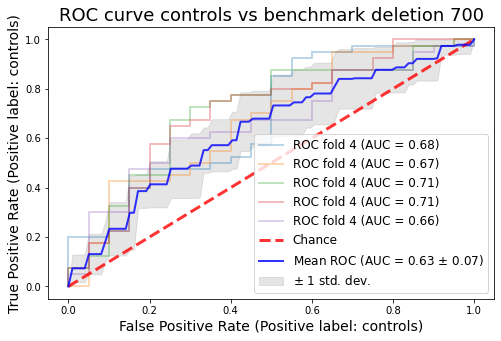

Accuracy: 0.670 (0.040)


In [87]:
fig, ax = plt.subplots(figsize=(8, 5))

cv_outer = StratifiedKFold(n_splits=5)

outer_results = list()
for train_ix, test_ix in cv_outer.split(X, label):
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = label[train_ix], label[test_ix]
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    model = LinearSVC(random_state=1, loss='squared_hinge', max_iter=10000)
    space = dict()
    space['penalty'] = ['l2']
    space['C'] = [0.7, 1, 1.2]
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        
    viz = metrics.plot_roc_curve(best_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large')
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark deletion 700', fontsize=18)
plt.show()
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

#### SS_size = 1000

In [180]:
list_encoded_1000 = random.sample(list(deletion_1000['sub']), 100)
df_encoded_1000_X = deletion_1000[deletion_1000['sub'].astype(int).isin(list_encoded_1000)]

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_1000_X['sub'].astype(int))))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

X_1000 = np.array(list(df_encoded_1000_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X['latent']))
X = np.array(list(df_encoded_hcp_X['latent']) + list(df_encoded_1000_X['latent']))

#X_embedded_1000 = TSNE(n_components=2, perplexity=15).fit_transform(X_all)
label = np.array(list(df_encoded_hcp_X['Group']) + ['1000' for k in range(len(df_encoded_1000_X))])
X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.4, stratify=label, random_state=42)

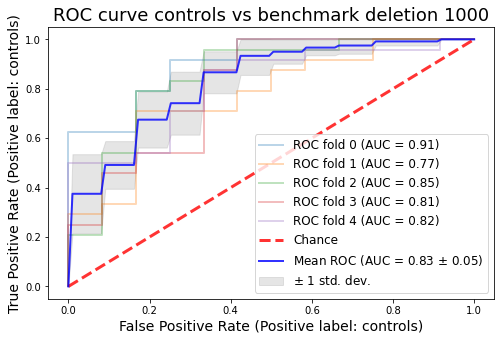

In [181]:
cv = StratifiedKFold(n_splits=5)
gb = GradientBoostingClassifier()

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(8, 5))
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    gb.fit(X_train[train], y_train[train])
    viz = metrics.plot_roc_curve(gb, X_train[test], y_train[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large')
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark deletion 1000', fontsize=18)
plt.show()

>acc=0.800, est=0.925, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.900, est=0.887, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.850, est=0.900, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.875, est=0.850, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.850, est=0.875, cfg={'C': 0.7, 'penalty': 'l2'}


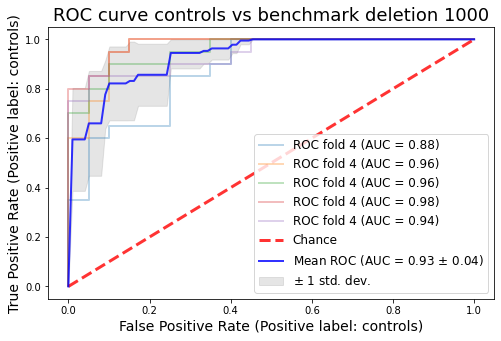

Accuracy: 0.855 (0.033)


In [504]:
fig, ax = plt.subplots(figsize=(8, 5))

cv_outer = StratifiedKFold(n_splits=5)

outer_results = list()
for train_ix, test_ix in cv_outer.split(X, label):
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = label[train_ix], label[test_ix]
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    model = LinearSVC(random_state=1, loss='squared_hinge', max_iter=10000)
    space = dict()
    space['penalty'] = ['l2']
    space['C'] = [0.7, 1, 1.2]
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        
    viz = metrics.plot_roc_curve(best_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large')
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark deletion 1000', fontsize=18)
plt.show()
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

In [450]:
cv_outer = StratifiedKFold(n_splits=5)

outer_results = list()
for train_ix, test_ix in cv_outer.split(X, label):
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = label[train_ix], label[test_ix]
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    model = LinearSVC(random_state=1, loss='squared_hinge', max_iter=10000)
    space = dict()
    space['penalty'] = ['l2']
    space['C'] = [0.7, 1, 1.2]
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

>acc=0.850, est=0.944, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.925, est=0.931, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.850, est=0.950, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.950, est=0.912, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.900, est=0.894, cfg={'C': 0.7, 'penalty': 'l2'}
Accuracy: 0.895 (0.040)


In [509]:
logreg = LogisticRegression(random_state=0, max_iter=500)
logreg.fit(X_train, y_train)
print(logreg.score(X_test, y_test))
imp = logreg.coef_
imp_abs = list([abs(imp[0][k]) for k in range(len(imp[0]))])
imp_abs, names = zip(*sorted(list(zip(list(imp[0]), [k for k in range(len(imp_abs))]))))
print(imp_abs[-5:], names[-5:])

0.925
(0.47259548992939254, 0.49529111953054633, 0.5229202121515772, 0.6186860195496223, 0.7971726362967814) (33, 57, 46, 29, 9)


In [510]:
gb = GradientBoostingClassifier(random_state=0)
gb.fit(X_train, y_train)
print(gb.score(X_test, y_test))
imp = gb.feature_importances_
imp, names = zip(*sorted(list(zip(imp, [k for k in range(len(imp))]))))
print(imp[-5:], names[-5:])

0.775
(0.06014379354569805, 0.111560468653352, 0.13090743741798322, 0.20154989199562107, 0.24520685998180336) (38, 9, 2, 29, 68)


## Benchmark Asymmetry

In [182]:
data_dir = '/neurospin/dico/lguillon/inpainting/benchmark/asymmetry/flip/'

In [183]:
distmaps_asym = np.load(os.path.join(data_dir, "asym_distmaps.npy"),
                   mmap_mode='r')
skeletons_asym = np.load(os.path.join(data_dir, "asym_skel.npy"),
                   mmap_mode='r')
foldlabels_asym = np.load(os.path.join(data_dir, "asym_labels.npy"),
                   mmap_mode='r')
filenames_asym = np.load(os.path.join(data_dir, "sub_id_skel.npy"))


subset_asym = InpaintDataset(foldlabels=foldlabels_asym,
                        skeletons=skeletons_asym,
                        distmaps=distmaps_asym,
                        filenames=filenames_asym,
                        data_transforms=False)
loader_asym = torch.utils.data.DataLoader(
               subset_asym,
               batch_size=1,
               num_workers=1,
               shuffle=False)

inpaint


In [184]:
dico_set_loaders = {'asymmetry': loader_asym}

root_dir = '/neurospin/dico/lguillon/distmap/benchmark/results/'

criterion = nn.MSELoss(reduction='sum')
tester_asym = ModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=100, depth=3)

results_asym = tester_asym.test()
encoded_asym = {loader_name:[results_asym[loader_name][k][1] for k in results_asym[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
losses_asym = {loader_name:[int(results_asym[loader_name][k][0].cpu().detach().numpy()) for k in results_asym[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
recon_asym = {loader_name:[int(results_asym[loader_name][k][2].cpu().detach().numpy()) for k in results_asym[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
input_asym = {loader_name:[results_asym[loader_name][k][3].cpu().detach().numpy() for k in results_asym[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

asymmetry


In [13]:
df_encoded_asym = pd.DataFrame()
df_encoded_asym['latent'] = encoded_asym['asymmetry']
df_encoded_asym['loss'] = losses_asym['asymmetry']  
df_encoded_asym['recon'] = recon_asym['asymmetry']   
df_encoded_asym['input'] = input_asym['asymmetry'] 
df_encoded_asym['sub'] = list(filenames_asym) 

In [16]:
X_asym = np.array(list(df_encoded_asym['latent']))
X_hcp = np.array(list(df_encoded_hcp['latent']))
X_all = np.array(list(df_encoded_hcp['latent']) + list(df_encoded_asym['latent']))

labels_asym = np.array(list(df_encoded_hcp['Group']) + ['asymmetry' for k in range(len(df_encoded_asym))])
reducer = umap.UMAP(random_state=14)
embedding_asym = reducer.fit_transform(X_all)

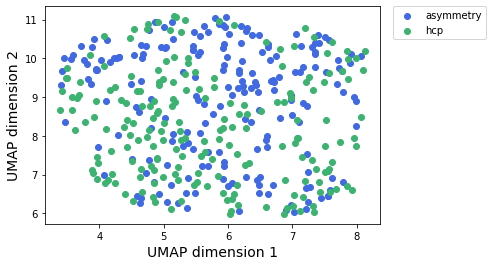

In [17]:
arr = embedding_asym
color_dict = {'hcp':'mediumseagreen', 'asymmetry': 'royalblue'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_asym):
    ix = np.where(labels_asym == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

In [39]:
np.array(list(cv_outer.split(X_all, labels_asym))).shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


(5, 2)

In [40]:
i=0
for train_ix, test_ix in cv_outer.split(X_all, labels_asym):
    i+=1
print(i)

5


>acc=0.812, est=0.725, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.713, est=0.738, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.787, est=0.741, cfg={'C': 1.2, 'penalty': 'l2'}
>acc=0.738, est=0.738, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.738, est=0.741, cfg={'C': 1, 'penalty': 'l2'}


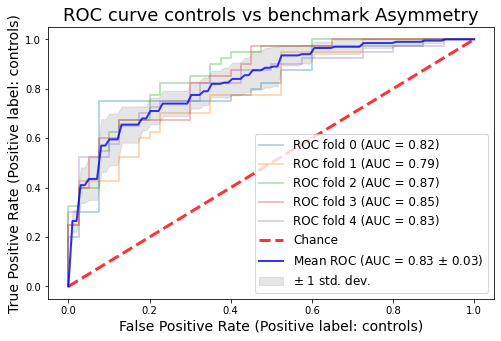

Accuracy: 0.757 (0.037)


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_all, labels_asym, test_size=0.4, stratify=labels_asym, random_state=42)

fig, ax = plt.subplots(figsize=(8, 5))

cv_outer = StratifiedKFold(n_splits=5)

outer_results = list()
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
i = 0
    
for train_ix, test_ix in cv_outer.split(X_all, labels_asym): 
    X_train, X_test = X_all[train_ix, :], X_all[test_ix, :]
    y_train, y_test = labels_asym[train_ix], labels_asym[test_ix]
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    model = LinearSVC(random_state=1, loss='squared_hinge', max_iter=10000)
    space = dict()
    space['penalty'] = ['l2']
    space['C'] = [0.7, 1, 1.2]
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
    viz = metrics.plot_roc_curve(best_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    i += 1  
    
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large')
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark Asymmetry', fontsize=18)
plt.show()
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

In [46]:
imp = best_model.coef_
imp_abs = list([abs(imp[0][k]) for k in range(len(imp[0]))])
imp_abs, names = zip(*sorted(list(zip(list(imp[0]), [k for k in range(len(imp_abs))]))))
print(imp_abs[-5:], names[-5:])

(0.6852518646374691, 0.8386553198322276, 0.8768181157096834, 0.8836716494745361, 1.0818545025938162) (27, 88, 16, 23, 81)


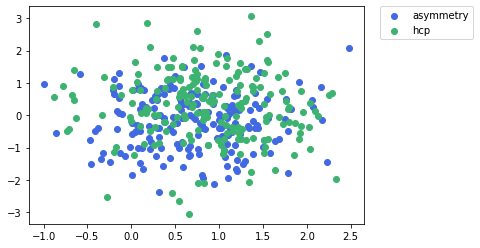

In [47]:
color_dict = {'hcp': 'mediumseagreen', 'asymmetry': 'royalblue'}
most_imp = [81, 23]
arr = np.array([np.array([X_all[i][k] for k in most_imp]) for i in range(len(X_all))])

fig = plt.figure()
ax = fig.add_subplot(111)

for g in np.unique(labels_asym):
    #if g == 'HCP' or g == 'leftHanders':
    ix = np.where(labels_asym == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    #ax.scatter(arr[ix][0], arr[ix][1], arr[ix][2], c = color_dict[g], label = g)
    g_lab=g
    ax.scatter(x, y, c = color_dict[g], label = g_lab)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
#ax.legend(fontsize=14)
plt.show()

## Folding space - loss distributions

In [69]:
len(df_encoded_deletion)

507

In [70]:
len(df_encoded_200_X)

180

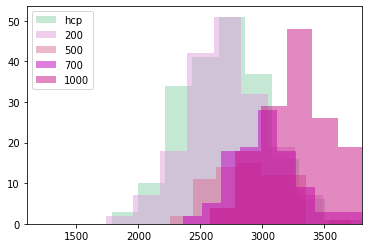

In [71]:
plt.subplot()
plt.xlim([1100, 3800])
plt.hist(df_encoded_hcp.loss, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_deletion[df_encoded_deletion.group=='200'].loss, color='plum', alpha=0.5, label='200')
plt.hist(df_encoded_deletion[df_encoded_deletion.group=='500'].loss, color='palevioletred', alpha=0.5, label='500')
plt.hist(df_encoded_deletion[df_encoded_deletion.group=='700'].loss, color='m', alpha=0.5, label='700') 
plt.hist(df_encoded_deletion[df_encoded_deletion.group=='1000'].loss, color='mediumvioletred', alpha=0.5, label='1000')
plt.legend()

In [72]:
F,p = mannwhitneyu(df_encoded_hcp.loss, df_encoded_deletion[df_encoded_deletion.group=='200'].loss)
print(p)
F,p = mannwhitneyu(df_encoded_hcp.loss, df_encoded_deletion[df_encoded_deletion.group=='500'].loss)
print(p)
F,p = mannwhitneyu(df_encoded_hcp.loss, df_encoded_deletion[df_encoded_deletion.group=='700'].loss)
print(p)
F,p = mannwhitneyu(df_encoded_hcp.loss, df_encoded_deletion[df_encoded_deletion.group=='1000'].loss)
print(p)

0.2805103679049844
4.187604822313454e-06
7.380906103911546e-17
5.273773743232593e-42


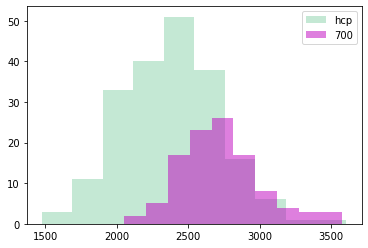

In [76]:
plt.subplot()
plt.hist(df_encoded_hcp.recon, color='mediumseagreen', alpha=0.3, label='hcp')
#plt.hist(df_encoded_deletion[df_encoded_deletion.group=='200'].recon, color='plum', alpha=0.5, label='200')
#plt.hist(df_encoded_deletion[df_encoded_deletion.group=='500'].recon, color='palevioletred', alpha=0.7, label='500')
plt.hist(df_encoded_deletion[df_encoded_deletion.group=='700'].recon, color='m', alpha=0.5, label='700') 
#plt.hist(df_encoded_deletion[df_encoded_deletion.group=='1000'].recon, color='mediumvioletred', alpha=0.7, label='1000')
plt.legend()

In [143]:
list_encoded_200 = random.sample(list(deletion_200['sub']), 100)
df_encoded_200_X = deletion_200[deletion_200['sub'].isin(list_encoded_200)]

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_200_X['sub'])))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

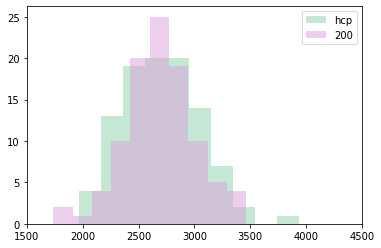

In [144]:
plt.subplot()
plt.xlim([1500, 4500])
plt.hist(df_encoded_hcp_X.loss, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_200_X.loss, color='plum', alpha=0.5, label='200')
plt.legend()

In [80]:
F,p = mannwhitneyu(df_encoded_hcp_X.loss, df_encoded_200_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X.loss, df_encoded_200_X.loss)
print(p)

0.3096021074502924
0.5632056973850592


In [138]:
df_encoded_500_X = deletion_500

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(deletion_500['sub'])))
random_ctrl = random.sample(list_ctrl, 100)
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(random_ctrl)]

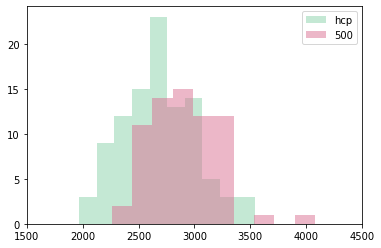

In [139]:
plt.subplot()
plt.xlim([1500, 4500])
plt.hist(df_encoded_hcp_X.loss, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_500_X.loss, color='palevioletred', alpha=0.5, label='500')
plt.legend()

In [140]:
F,p = mannwhitneyu(df_encoded_hcp_X.loss, df_encoded_500_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X.loss, df_encoded_500_X.loss)
print(p)

1.0265796500613983e-05
0.00020874918560124945


In [134]:
list_encoded_700 = random.sample(list(deletion_700['sub']), 100)
df_encoded_700_X = deletion_700[deletion_700['sub'].isin(list_encoded_700)]
list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_700_X['sub'])))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

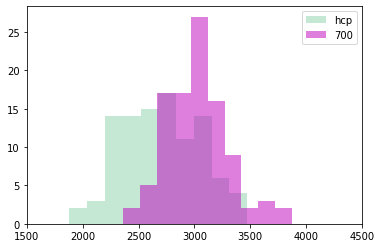

In [135]:
plt.subplot()
plt.xlim([1500, 4500])
plt.hist(df_encoded_hcp_X.loss, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_700_X.loss, color='m', alpha=0.5, label='700') 
plt.legend()

In [136]:
F,p = mannwhitneyu(df_encoded_hcp_X.loss, df_encoded_700_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X.loss, df_encoded_700_X.loss)
print(p)

7.263030519368668e-11
2.2056176563845718e-08


In [123]:
list_encoded_1000 = random.sample(list(deletion_1000['sub']), 100)
df_encoded_1000_X = deletion_1000[deletion_1000['sub'].isin(list_encoded_1000)]
list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_1000_X['sub'])))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

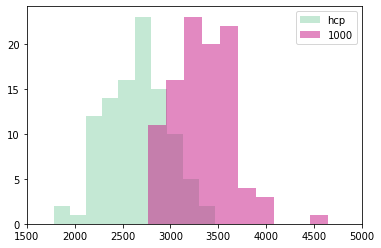

In [133]:
plt.subplot()
plt.xlim([1500, 5000])
plt.hist(df_encoded_hcp_X.loss, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_1000_X.loss, color='mediumvioletred', alpha=0.5, label='1000') 
plt.legend()

In [130]:
F,p = mannwhitneyu(df_encoded_hcp_X.loss, df_encoded_1000_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X.loss, df_encoded_1000_X.loss)
print(p)

5.459570929393207e-28
3.96731522238869e-25


In [96]:
df_200_500 = pd.merge(deletion_200, deletion_500, how='inner', on='sub', suffixes=('_200', '_500'))
df_700_1000 = pd.merge(deletion_700, deletion_1000, how='inner', on='sub', suffixes=('_700', '_1000'))
deletion_all = pd.merge(df_200_500, df_700_1000, how='inner', on='sub')

In [97]:
list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(deletion_all['sub'].astype(int))))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

In [262]:
# plt.subplot()
# plt.xlim([1100, 3800])
# plt.hist(df_encoded_hcp_X[:50].loss, color='mediumseagreen', alpha=0.3, label='hcp')
# # plt.scatter(deletion_all.loss_200[:1], [1], color='plum', alpha=0.8, label='200') 
# # plt.scatter(deletion_all.loss_500[:1], [1], color='palevioletred', alpha=0.8, label='500') 
# # plt.scatter(deletion_all.loss_700[:1], [1], color='m', alpha=0.8, label='700') 
# # plt.scatter(deletion_all.loss_1000[:1], [1], color='mediumvioletred', alpha=0.8, label='1000') 

# plt.scatter(deletion_all.loss_200[1], [2], color='plum', alpha=0.8, label='200', marker='o') 
# plt.scatter(deletion_all.loss_500[1], [2], color='palevioletred', alpha=0.8, label='500', marker='o') 
# plt.scatter(deletion_all.loss_700[1], [2], color='m', alpha=0.8, label='700', marker='o') 
# plt.scatter(deletion_all.loss_1000[1], [2], color='mediumvioletred', alpha=0.8, label='1000', marker='o') 

# plt.plot(deletion_all.loss_200[2], [2], color='plum', alpha=0.8, label='200', marker='->') 
# plt.scatter(deletion_all.loss_500[2], [2], color='palevioletred', alpha=0.8, label='500', marker='->') 
# plt.scatter(deletion_all.loss_700[2], [2], color='m', alpha=0.8, label='700', marker='->') 
# plt.scatter(deletion_all.loss_1000[2], [2], color='mediumvioletred', alpha=0.8, label='1000', marker='->') 

# # plt.scatter(deletion_all.loss_200[3], [3], color='plum', alpha=0.8, label='200', marker='X') 
# # plt.scatter(deletion_all.loss_500[3], [3], color='palevioletred', alpha=0.8, label='500', marker='X') 
# # plt.scatter(deletion_all.loss_700[3], [3], color='m', alpha=0.8, label='700', marker='X') 
# # plt.scatter(deletion_all.loss_1000[3], [3], color='mediumvioletred', alpha=0.8, label='1000', marker='X') 

# # plt.hist(deletion_all.loss_700, color='m', alpha=0.5, label='700') 
# # plt.hist(deletion_all.loss_1000, color='mediumvioletred', alpha=0.5, label='1000') 


# # plt.plot(np.histogram(list(deletion_all.loss_200))[1][:-1],np.histogram(list(deletion_all.loss_200))[0], color='plum', alpha=0.8, label='200') # plt.hist(deletion_all.loss_500, color='palevioletred', alpha=0.5, label='500') 
# # plt.plot(np.histogram(list(deletion_all.loss_500))[1][:-1],np.histogram(list(deletion_all.loss_500))[0], color='palevioletred', alpha=0.8, label='500') # plt.hist(deletion_all.loss_500, color='palevioletred', alpha=0.5, label='500') 
# # plt.plot(np.histogram(list(deletion_all.loss_700))[1][:-1],np.histogram(list(deletion_all.loss_700))[0], color='m', alpha=0.8, label='500') # plt.hist(deletion_all.loss_500, color='palevioletred', alpha=0.5, label='500') 
# # plt.plot(np.histogram(list(deletion_all.loss_1000))[1][:-1],np.histogram(list(deletion_all.loss_1000))[0], color='mediumvioletred', alpha=0.8, label='500') # plt.hist(deletion_all.loss_500, color='palevioletred', alpha=0.5, label='500') 

# plt.legend()

In [110]:
delta_loss_200, delta_loss_500, delta_loss_700, delta_loss_1000 = [], [], [], []
for k in range(len(deletion_all)):
    sub = deletion_all['sub'][k]
    delta = (deletion_all['loss_200'].values[k] - df_encoded_hcp[df_encoded_hcp['sub']==sub].loss.values)[0]
    delta_loss_200.append(delta)
    
    delta = (deletion_all['loss_500'].values[k] - df_encoded_hcp[df_encoded_hcp['sub']==sub].loss.values)[0]
    delta_loss_500.append(delta)
    
    delta = (deletion_all['loss_700'].values[k] - df_encoded_hcp[df_encoded_hcp['sub']==sub].loss.values)[0]
    delta_loss_700.append(delta)
    
    delta = (deletion_all['loss_1000'].values[k] - df_encoded_hcp[df_encoded_hcp['sub']==sub].loss.values)[0]
    delta_loss_1000.append(delta)

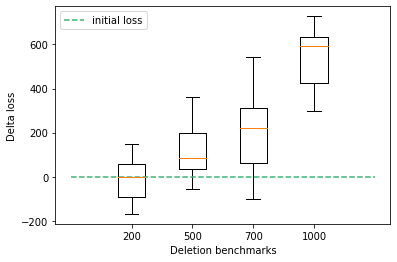

In [111]:
plt.boxplot((delta_loss_200, delta_loss_500, delta_loss_700, delta_loss_1000),
            labels=('200','500','700','1000'))
plt.plot(['0','200','500','700','1000', '2000'], [0, 0, 0, 0, 0, 0], color='mediumseagreen', ls='--',
        label='initial loss')
plt.xlabel('Deletion benchmarks')
plt.ylabel('Delta loss')
plt.legend()

### Asymmetry

In [112]:
list_encoded_asym = random.sample(list(df_encoded_asym['sub']), 100)
df_encoded_asym_X = df_encoded_asym[df_encoded_asym['sub'].astype(int).isin(list_encoded_asym)]

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_asym_X['sub'].astype(int))))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

NameError: name 'df_encoded_asym' is not defined

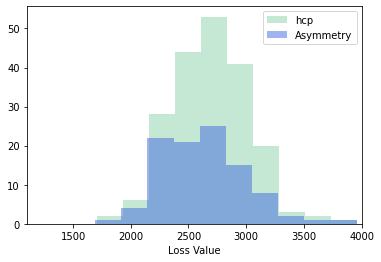

In [50]:
plt.subplot()
plt.xlim([1100, 4000])
plt.hist(df_encoded_hcp_X.loss, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_asym_X.loss, color='royalblue', alpha=0.5, label='Asymmetry') 
plt.xlabel('Loss Value')
plt.legend()

In [51]:
F,p = mannwhitneyu(df_encoded_hcp_X.loss, df_encoded_asym_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X.loss, df_encoded_asym_X.loss)
print(p)

0.04827931982685287
0.11049822222033816
